# Random Forest Classifier -> `train_model_v3.ipynb`

This ensures theres a 20:80 C2 to normal split for each run.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


## Load extracted features CSV

In [2]:
# Load full combined dataset
# df = pd.read_csv("../../data/combined_datasets/combined_1.csv")
df = pd.read_csv("../../data/mixed/metasploit_mixed_0.csv")

# Split into normal and C2
normal_df = df[df["c2_label"] == 0]
c2_df = df[df["c2_label"] == 1]

# Target class ratio: 20% C2, 80% normal
desired_c2_ratio = 0.2
desired_normal_ratio = 0.8

# Determine how many normal samples are needed to match 20:80
normal_needed = int((len(c2_df) / desired_c2_ratio) * desired_normal_ratio)

# Subsample normal traffic if necessary
if len(normal_df) > normal_needed:
    normal_df = normal_df.sample(n=normal_needed, random_state=42)
    print(f"Subsampled normal traffic to {normal_needed} rows to maintain 20:80 class balance.")

# Combine balanced dataset
df_balanced = pd.concat([c2_df, normal_df], ignore_index=True)
df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)  # shuffle


Subsampled normal traffic to 6428 rows to maintain 20:80 class balance.


## Preprocessing

In [3]:
# Separate Predictors and Target Variable
X = df_balanced.drop(columns=["c2_label"])
y = df_balanced["c2_label"]

In [4]:
# Normalize the Predictors
scaler = StandardScaler() # initialize the scaler

X_scaled = scaler.fit_transform(X) # fit the scaler to the data and transform X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=32, stratify=y) # pick 40% of the data for testing, make sure ratio of classes is the same in the training and testing sets

print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")


Training size: (4821, 18), Testing size: (3214, 18)


## Train

In [5]:
# Train the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# Evaluate Model Performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9698


## Post-Training Visualizations

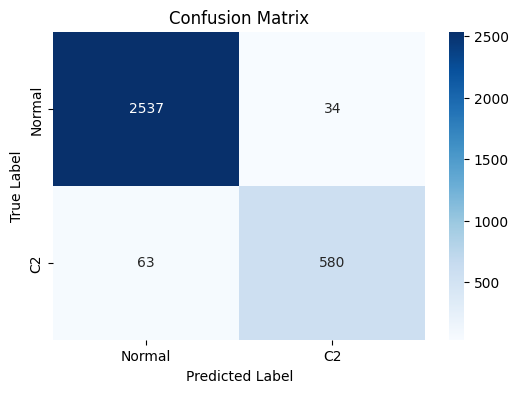

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "C2"], yticklabels=["Normal", "C2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [8]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2571
           1       0.94      0.90      0.92       643

    accuracy                           0.97      3214
   macro avg       0.96      0.94      0.95      3214
weighted avg       0.97      0.97      0.97      3214



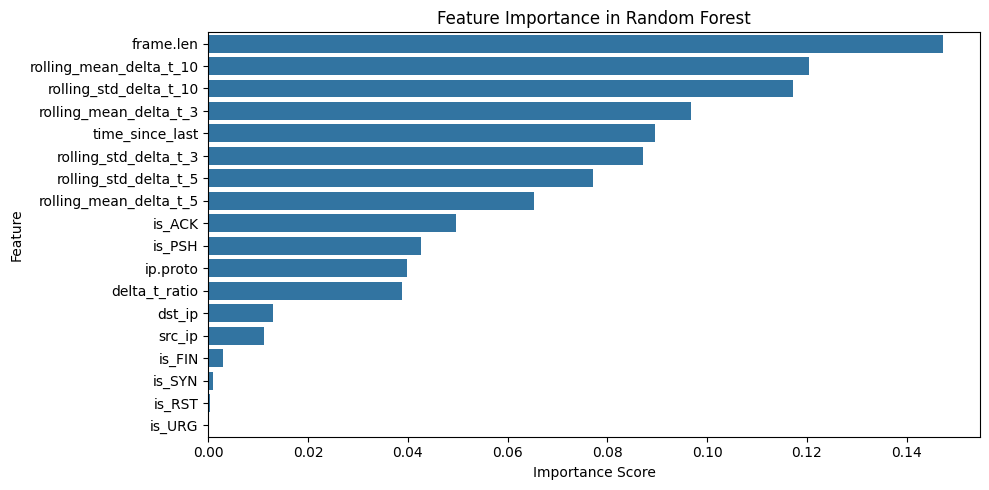

In [9]:
# Feature Importance (for Random Forest)
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.tight_layout()
plt.show()


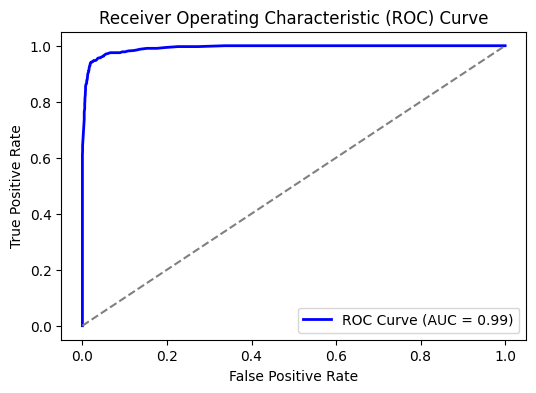

In [10]:
## ROC Curve and AUC Score
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

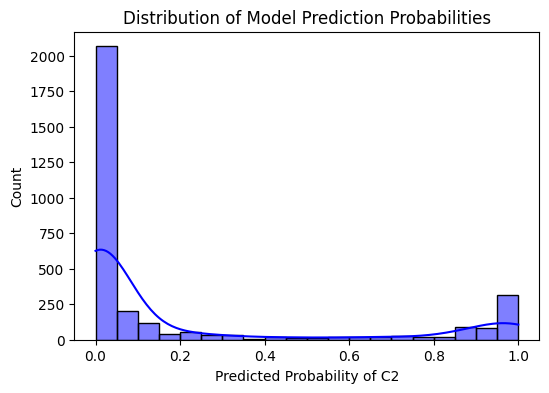

In [11]:
# Histogram of Predicted Probabilities
plt.figure(figsize=(6,4))
sns.histplot(model.predict_proba(X_test)[:, 1], bins=20, kde=True, color="blue")
plt.xlabel("Predicted Probability of C2")
plt.ylabel("Count")
plt.title("Distribution of Model Prediction Probabilities")
plt.show()


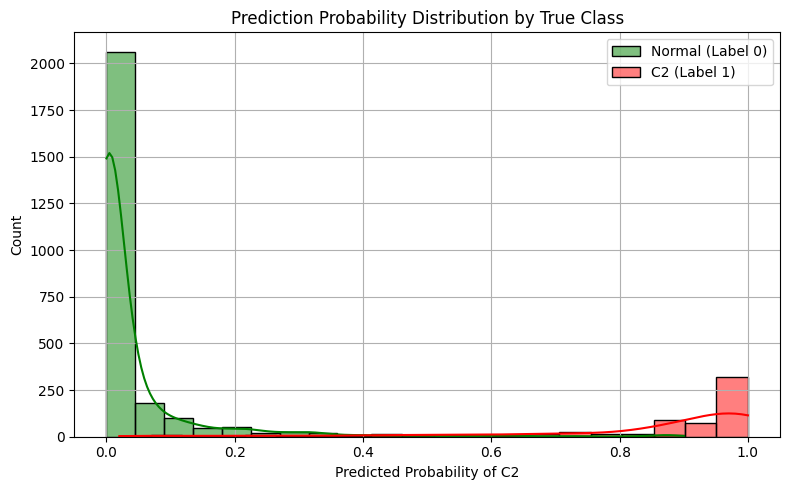

In [12]:
# Get prediction probabilities for the positive class (C2)
y_probs = model.predict_proba(X_test)[:, 1]

# Plot the distributions separately by true label
plt.figure(figsize=(8, 5))
sns.histplot(y_probs[y_test == 0], bins=20, kde=True, color="green", label="Normal (Label 0)", stat="count", alpha=0.5)
sns.histplot(y_probs[y_test == 1], bins=20, kde=True, color="red", label="C2 (Label 1)", stat="count", alpha=0.5)

plt.xlabel("Predicted Probability of C2")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution by True Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Save Model & Generate Report

Change the `Config` section to reflect each run

In [13]:
import os
from datetime import datetime
from collections import Counter
import joblib

# === Config ===
DATASET_NAME = "metasploit_mixed_0"
NOTES = "Includes c2 and normal traffic (20:80 ratio). Random Forest Classification. 40% test split. Stratified sampling. Normalized features."
FRAMEWORKS = ["Metasploit"]
EXPERIMENT_ID = f"{DATASET_NAME}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# === Directories ===
REPORT_DIR = "experiment_reports_20_80_ratio_enforced"
IMG_DIR = os.path.join(REPORT_DIR, "images")
MODEL_DIR = os.path.join(REPORT_DIR, "models")
os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# === Class Counts ===
class_counts = Counter(y_test)
c2_ratio = round(class_counts[1] / sum(class_counts.values()), 4)

# === Save Model + Scaler + Feature Columns ===
MODEL_NAME = f"{DATASET_NAME}_rf_model.joblib"
SCALER_NAME = f"{DATASET_NAME}_scaler.joblib"
FEATURES_NAME = f"{DATASET_NAME}_feature_columns.joblib"

model_path = os.path.join(MODEL_DIR, MODEL_NAME)
scaler_path = os.path.join(MODEL_DIR, SCALER_NAME)
features_path = os.path.join(MODEL_DIR, FEATURES_NAME)

joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(list(X.columns), features_path)

# === Save Plots ===

# 1. Pie Chart
plt.figure(figsize=(5, 5))
labels = ["Normal", "C2"]
sizes = [class_counts[0], class_counts[1]]
colors = ["green", "red"]
explode = (0, 0.1)

def autopct_format(pct, all_vals):
    count = int(round(pct/100. * sum(all_vals)))
    return f"{pct:.1f}%\n({count})"

plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: autopct_format(pct, sizes),
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={"fontsize": 10}
)
plt.title("Class Distribution in Test Set")
pie_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_pie.png")
plt.savefig(pie_path)
plt.close()

# 2. Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "C2"], yticklabels=["Normal", "C2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
conf_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_confusion.png")
plt.savefig(conf_path)
plt.close()

# 3. Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Classification")
feat_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_feature_importance.png")
plt.tight_layout()
plt.savefig(feat_path)
plt.close()

# 4. ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
roc_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_roc.png")
plt.savefig(roc_path)
plt.close()

# 5. Prediction Probabilities by Class
plt.figure(figsize=(8, 5))
sns.histplot(y_probs[y_test == 0], bins=20, kde=True, color="green", label="Normal (Label 0)", stat="count", alpha=0.5)
sns.histplot(y_probs[y_test == 1], bins=20, kde=True, color="red", label="C2 (Label 1)", stat="count", alpha=0.5)
plt.xlabel("Predicted Probability of C2")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution by True Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
hist_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_hist.png")
plt.savefig(hist_path)
plt.close()

# === Write Report ===
report_path = os.path.join(REPORT_DIR, f"{EXPERIMENT_ID}.md")
with open(report_path, "w") as f:
    f.write(f"# Experiment Report: {DATASET_NAME}\n\n")
    f.write(f"- **Experiment ID:** {EXPERIMENT_ID}\n")
    f.write(f"- **Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"- **Frameworks:** {', '.join(FRAMEWORKS)}\n")

    f.write("\n## Notes\n")
    f.write(f"{NOTES}\n\n")

    f.write("## Test Set Class Distribution\n")
    f.write(f"![Class Distribution Pie Chart](images/{os.path.basename(pie_path)})\n\n")

    f.write("## Confusion Matrix\n")
    f.write(f"![Confusion Matrix](images/{os.path.basename(conf_path)})\n\n")

    f.write("## Classification Report\n")
    f.write("```\n")
    f.write(classification_report(y_test, y_pred))
    f.write("```\n\n")

    f.write("## ROC Curve\n")
    f.write(f"![ROC Curve](images/{os.path.basename(roc_path)})\n\n")

    f.write("## Feature Importance\n")
    f.write(f"![Feature Importance](images/{os.path.basename(feat_path)})\n\n")

    f.write("## Prediction Probability Distribution by True Class\n")
    f.write(f"![Prediction Histogram](images/{os.path.basename(hist_path)})\n\n")

    f.write("---\n")
    f.write("## Model Artifacts\n")
    f.write(f"- Model file: `{model_path}`\n")
    f.write(f"- Scaler file: `{scaler_path}`\n")
    f.write(f"- Feature list file: `{features_path}`\n")

print(f"Markdown report saved: {report_path}")


Markdown report saved: experiment_reports_20_80_ratio_enforced\metasploit_mixed_0_2025-04-12_20-25-05.md
